In [5]:
import numpy as np                      # Para operaciones vectoriales y matriciales
import matplotlib.pyplot as plt         # Para visualización de datos
from mpl_toolkits.mplot3d import Axes3D # Para gráficos 3D
import pandas as pd                     # Para manejo de datos tabulares
from typing import Callable             # Para anotaciones de tipos

In [6]:
class GaussNewton:
    def __init__(self):
        # Historial de energía y posiciones
        self.energy_history = []
        self.positions_history = []
        
    def optimize(self, 
                 initial_positions: np.ndarray, 
                 residual_func: Callable, 
                 jacobian_func: Callable, 
                 energy_func: Callable, 
                 max_iter: int = 100, 
                 tol: float = 1e-6):
        ''' 
        Optimización utilizando el método de Gauss-Newton.

        Args:
            initial_positions (np.ndarray): Posiciones iniciales de las partículas.
            residual_func (Callable): Función que calcula el vector de residuos.
            jacobian_func (Callable): Función que calcula la matriz Jacobiana.
            energy_func (Callable): Función que calcula la energía total del sistema.
            max_iter (int): Número máximo de iteraciones.
            tol (float): Tolerancia para el criterio de convergencia.

        Returns:
            positions (np.ndarray): Posiciones optimizadas de las partículas.
            energy (float): Energía mínima alcanzada.
        '''

        positions = initial_positions.copy()
        self.energy_history = []
        self.positions_history = []
        
        for iteration in range(max_iter):
            # Calcular energía actual
            energy = energy_func(positions)
            self.energy_history.append(energy)
            self.positions_history.append(positions.copy())
            
            # Calcular residual y jacobiano
            residual = residual_func(positions)
            jacobian = jacobian_func(positions)
            
            # Verificar convergencia
            if np.linalg.norm(residual) < tol:
                print(f"Convergió en {iteration} iteraciones")
                break
            
            # Paso de Gauss-Newton: J^T J delta = -J^T r

            JTJ = jacobian.T @ jacobian
            JTr = jacobian.T @ residual
            
            # Regularización para estabilidad numérica
            reg = 1e-8 * np.eye(JTJ.shape[0])
            delta = np.linalg.solve(JTJ + reg, -JTr)
            
            # Actualizar posiciones
            delta_reshaped = delta.reshape(positions.shape)
            
            # Line search simple
            alpha = 1.0
            new_positions = positions + alpha * delta_reshaped
            new_energy = energy_func(new_positions)
            
            # Reducir alpha si la energía aumenta
            while new_energy > energy and alpha > 1e-4:
                alpha *= 0.5
                new_positions = positions + alpha * delta_reshaped
                new_energy = energy_func(new_positions)
            
            positions = new_positions
                
        
        return positions, energy
    
    def plot_energy_convergence(self):
        """
        Gráfica la convergencia de la funcion de energia.

        Args:
            None, usa los datos almacenados en la instancia.

        Returns:
            None, solo muestra la gráfica.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.energy_history, 'b-', linewidth=2)
        plt.xlabel('Iteración')
        plt.ylabel('Energía de Lennard-Jones')
        plt.title('Convergencia de la Energía')
        plt.grid(True)
        plt.show()
    
    def plot_final_configuration(self, final_positions):
        """
        Gráfica la configuración final en 3D.

        Args:
            final_positions (np.ndarray): Posiciones finales de las partículas.

        Returns:
            None, solo muestra la gráfica.
        """
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plotear partículas
        ax.scatter(final_positions[:, 0], final_positions[:, 1], final_positions[:, 2], 
                  c='red', s=100, alpha=0.8)
        
        # Conectar partículas cercanas con líneas
        N = final_positions.shape[0]
        for i in range(N):
            for j in range(i+1, N):
                dist = np.linalg.norm(final_positions[i] - final_positions[j])
                if dist < 2.0:  # Solo conectar partículas cercanas
                    ax.plot([final_positions[i, 0], final_positions[j, 0]],
                           [final_positions[i, 1], final_positions[j, 1]],
                           [final_positions[i, 2], final_positions[j, 2]], 
                           'k-', alpha=0.3)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y') 
        ax.set_zlabel('Z')
        ax.set_title(f'Configuración Final - {N} Partículas')
        plt.show()


In [7]:
# Funcion de Lennard-Jones
def lennard_jones_energy(positions):
    N = positions.shape[0]
    energy = 0.0
    
    for i in range(N):
        for j in range(i+1, N):
            r_ij = np.linalg.norm(positions[i] - positions[j])
            if r_ij > 1e-10:  # Evitar división por cero
                r_inv = 1.0 / r_ij
                energy += 4 * (r_inv**12 - r_inv**6)
    
    return energy

# Funciones de residual de Lennard-Jones
def lennard_jones_residual(positions):
    N = positions.shape[0]
    gradient = np.zeros_like(positions)
    
    for i in range(N):
        for j in range(N):
            if i != j:
                r_vec = positions[i] - positions[j]
                r_ij = np.linalg.norm(r_vec)
                if r_ij > 1e-10:
                    r_inv = 1.0 / r_ij
                    factor = 4 * (-12 * r_inv**14 + 6 * r_inv**8)
                    gradient[i] += factor * r_vec
    
    return gradient.flatten()


# Función Jacobiana de Lennard-Jones
def lennard_jones_jacobian(positions):
    N = positions.shape[0]
    dim = 3 * N
    jacobian = np.zeros((dim, dim))
    
    for i in range(N):
        for j in range(N):
            if i != j:
                r_vec = positions[i] - positions[j]
                r_ij = np.linalg.norm(r_vec)
                if r_ij > 1e-10:
                    r_inv = 1.0 / r_ij
                    
                    # Términos de la segunda derivada
                    factor1 = 4 * (-12 * r_inv**14 + 6 * r_inv**8)
                    factor2 = 4 * (168 * r_inv**16 - 48 * r_inv**10)
                    
                    # Matriz identidad por factor1
                    for k in range(3):
                        jacobian[3*i + k, 3*i + k] += factor1
                    
                    # Término de producto exterior
                    outer = np.outer(r_vec, r_vec) * factor2
                    for k in range(3):
                        for l in range(3):
                            jacobian[3*i + k, 3*i + l] += outer[k, l]
    
    return jacobian

Optimizando para N = 25 partículas
Energía final calculada: -8.144309
Energía de referencia: -102.372663
Error: 94.228354


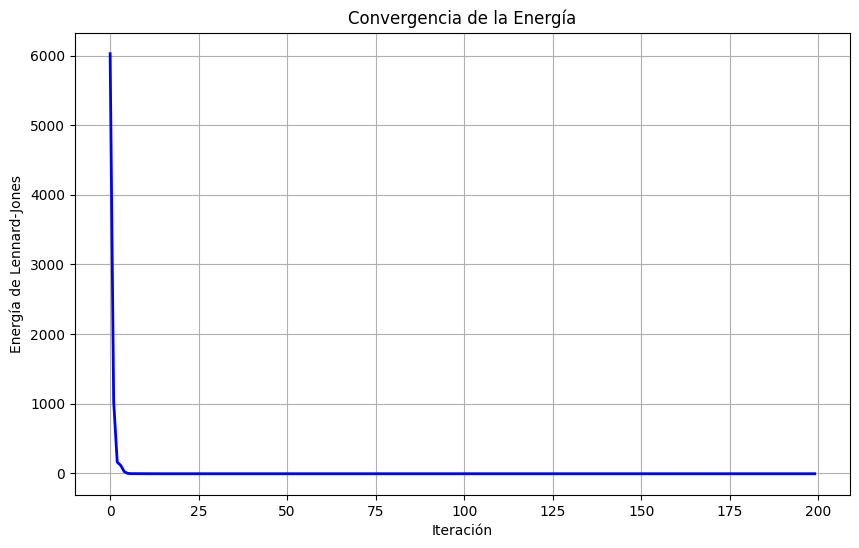

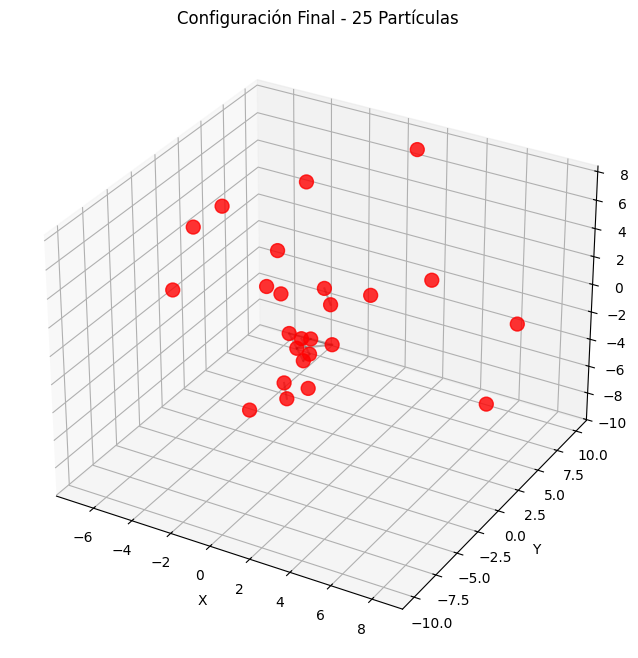

In [8]:
# Cargar datos de referencia
df = pd.read_csv('Lennard-Jones energy levels.csv')
reference_data = dict(zip(df['N'], df['Energy']))

# Seleccionamos un N>=2
N = 25
np.random.seed(42)

# Posiciones iniciales aleatorias
initial_positions = np.random.randn(N, 3) * 2.0

# Instancia del optimizador Gauss-Newton
optimizer = GaussNewton()

print(f"Optimizando para N = {N} partículas")
final_positions, final_energy = optimizer.optimize(
    initial_positions, 
    lennard_jones_residual, 
    lennard_jones_jacobian, 
    lennard_jones_energy,
    max_iter=200,
    tol=1e-6
)

print(f"Energía final calculada: {final_energy:.6f}")

# Comparar con datos de referencia
ref_energy = reference_data[N]
error = abs(final_energy - ref_energy)
print(f"Energía de referencia: {ref_energy:.6f}")
print(f"Error: {error:.6f}")

# Graficar resultados
optimizer.plot_energy_convergence()
optimizer.plot_final_configuration(final_positions)